In [42]:
from ppm import *
from util import *

In [43]:
lanes = 6
pattern = block_pattern(6, 20, 0.1)

In [44]:
ppm_simple = PPM(lanes)
for (p, (g1, g2, g3)) in pattern:
    ppm_simple.add_gate(g1, p, True)
    ppm_simple.add_gate('HSH', p, True)
    ppm_simple.add_gate('HSH', p + 1, True)
    ppm_simple.add_gate(g2, p + 1, True)
    ppm_simple.add_gate(g3, (p, p + 1), True)
    ppm_simple.add_gate('HSH', p, True)
    ppm_simple.add_gate('HSH', p + 1, True)

In [45]:
print(ppm_simple.stats())

Height: 76, Qubits: 597, Edges: 641, Long Edges: 32, TCount: 14


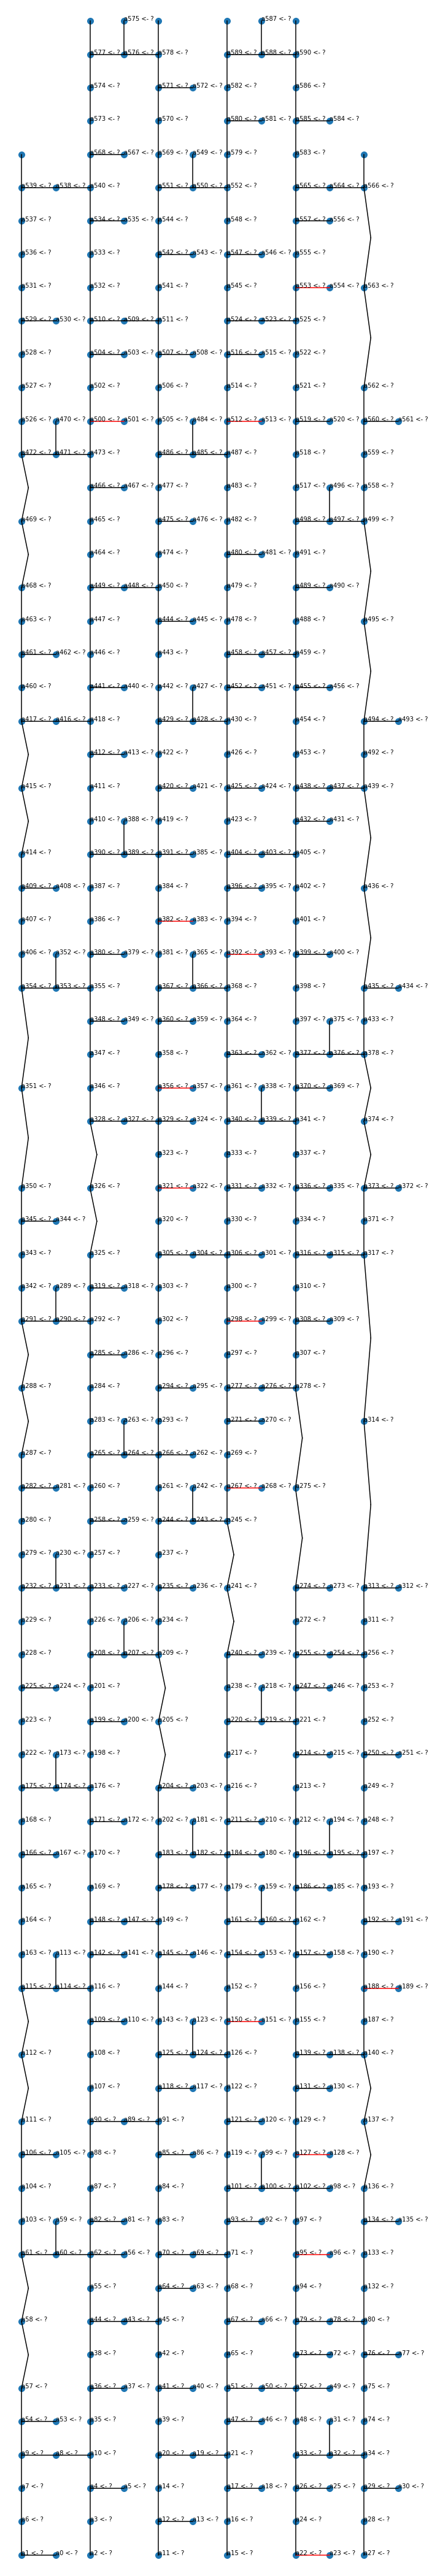

In [46]:
ppm_simple.draw("simple_original.png")

In [47]:
ppm = PPM(lanes)
for (p, (g1, g2, g3)) in pattern:
    ppm.add_gate(g1, p)
    ppm.add_gate('HSH', p)
    ppm.add_gate('HSH', p + 1)
    ppm.add_gate(g2, p + 1)
    ppm.add_gate(g3, (p, p + 1))
    ppm.add_gate('HSH', p)
    ppm.add_gate('HSH', p + 1)

In [48]:
print(ppm.stats())

Height: 80, Qubits: 860, Edges: 904, Long Edges: 18, TCount: 14


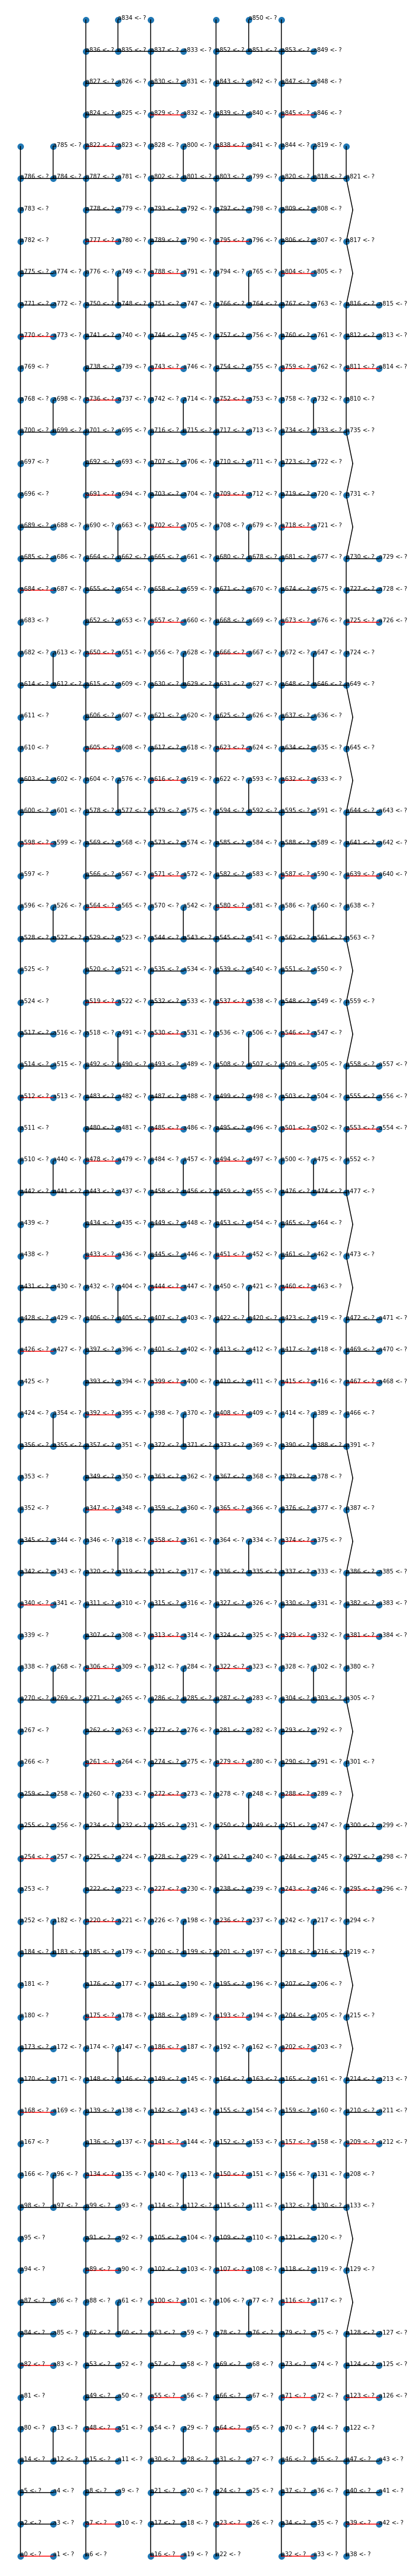

In [49]:
ppm.draw("original.png")

In [50]:
import pyzx as zx
from pyzx import Circuit
from fractions import Fraction
circuit = Circuit(qubit_amount=lanes)


In [51]:
def add_circuit_gate(circuit, gate, position):
    if gate == 'HSH':
        circuit.add_gate('XPhase', position, phase=Fraction(1, 2))
    elif gate == 'H':
        circuit.add_gate('HAD', position)
    elif gate == 'S':
        circuit.add_gate('ZPhase', position, phase=Fraction(1, 2))
    elif gate == 'T':
         circuit.add_gate('ZPhase', position, phase=Fraction(1, 4))
    elif gate == 'Split':
        (p1, p2) = position
        circuit.add_gate('ZPhase', p1, phase=Fraction(1, 2))
        circuit.add_gate('ZPhase', p2, phase=Fraction(1, 2))
    elif gate == 'CZ':
        (p1, p2) = position
        circuit.add_gate('CZ', p1, p2)

In [52]:
for (p, (g1, g2, g3)) in pattern:
    add_circuit_gate(circuit, g1, p)
    add_circuit_gate(circuit, 'HSH', p)
    add_circuit_gate(circuit, 'HSH', p + 1)
    add_circuit_gate(circuit, g2, p + 1)
    add_circuit_gate(circuit, g3, (p, p + 1))
    add_circuit_gate(circuit, 'HSH', p)
    add_circuit_gate(circuit, 'HSH', p + 1)

In [53]:
print(circuit.stats())

Circuit  on 6 qubits with 373 gates.
        14 is the T-count
        359 Cliffords among which 
        27 2-qubit gates (0 CNOT, 27 other) and
        41 Hadamard gates.


In [54]:
graph = circuit.to_graph()

In [55]:
zx.simplify.full_reduce(graph)

In [56]:
c2 = zx.extract_circuit(graph).to_basic_gates()
print(c2.stats())

Circuit  on 6 qubits with 92 gates.
        14 is the T-count
        78 Cliffords among which 
        39 2-qubit gates (8 CNOT, 31 other) and
        32 Hadamard gates.


In [57]:
from pyzx.circuit import ZPhase, CZ, CNOT, HAD

In [58]:
def add_gate_to_ppm(gate, ppm, simple=False):
    if isinstance(gate, CNOT):
        ppm.add_gate('H', gate.target, simple)
        if gate.control < gate.target:
            ppm.add_gate('CZ', (gate.control, gate.target), simple)
        else:
            ppm.add_gate('CZ', (gate.target, gate.control), simple)
        ppm.add_gate('H', gate.target, simple)

    elif isinstance(gate, CZ):
        if gate.control < gate.target:
            ppm.add_gate('CZ', (gate.control, gate.target), simple)
        else:
            ppm.add_gate('CZ', (gate.target, gate.control), simple)
    elif isinstance(gate, HAD):
        ppm.add_gate('H', gate.target, simple)
    elif isinstance(gate, ZPhase):
        if gate.phase == Fraction(1, 4):
            ppm.add_gate('T', gate.target, simple)
        elif gate.phase == Fraction(1, 2):
            ppm.add_gate('S', gate.target, simple)
        elif gate.phase == Fraction(3, 4):
            ppm.add_gate('T', gate.target, simple)
            ppm.add_gate('S', gate.target, simple)
        elif gate.phase == 1:
            ppm.add_gate('NEGZ', gate.target, simple)
        else:
            ppm.add_gate('NEGZ', gate.target, simple)
            gate.phase -= 1
            add_gate_to_ppm(gate, ppm, simple)
    else:
        raise Exception("Unknown Gate")

In [59]:
ppm_result = PPM(lanes)

In [60]:
for g in c2.gates:
    add_gate_to_ppm(g, ppm_result)

In [61]:
print(ppm_result.stats())

Height: 162, Qubits: 697, Edges: 730, Long Edges: 80, TCount: 14


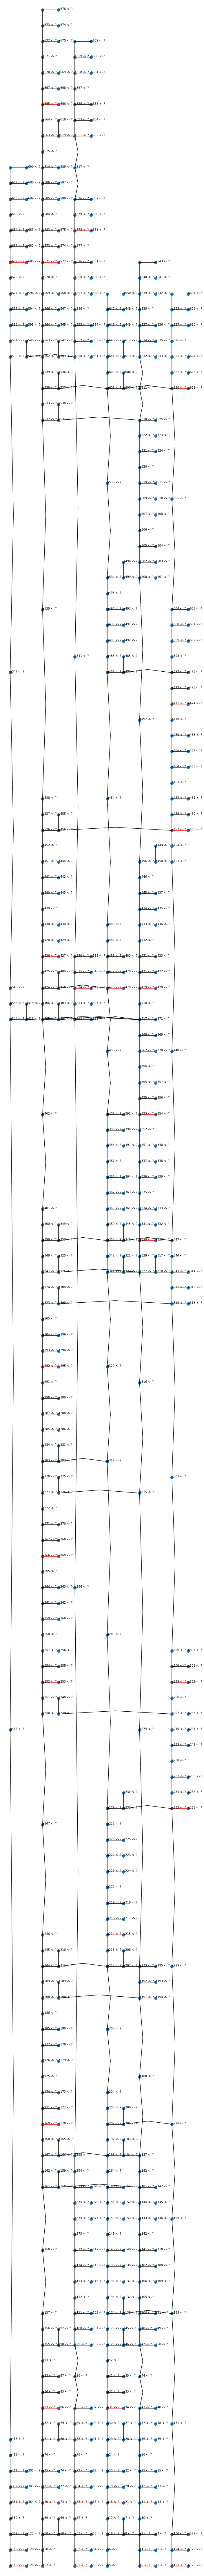

In [63]:
ppm_result.draw("optimized.png")

In [64]:
ppm_result_simple = PPM(lanes)
for g in c2.gates:
    add_gate_to_ppm(g, ppm_result_simple, True)

In [65]:
print(ppm_result_simple.stats())

Height: 126, Qubits: 489, Edges: 522, Long Edges: 78, TCount: 14


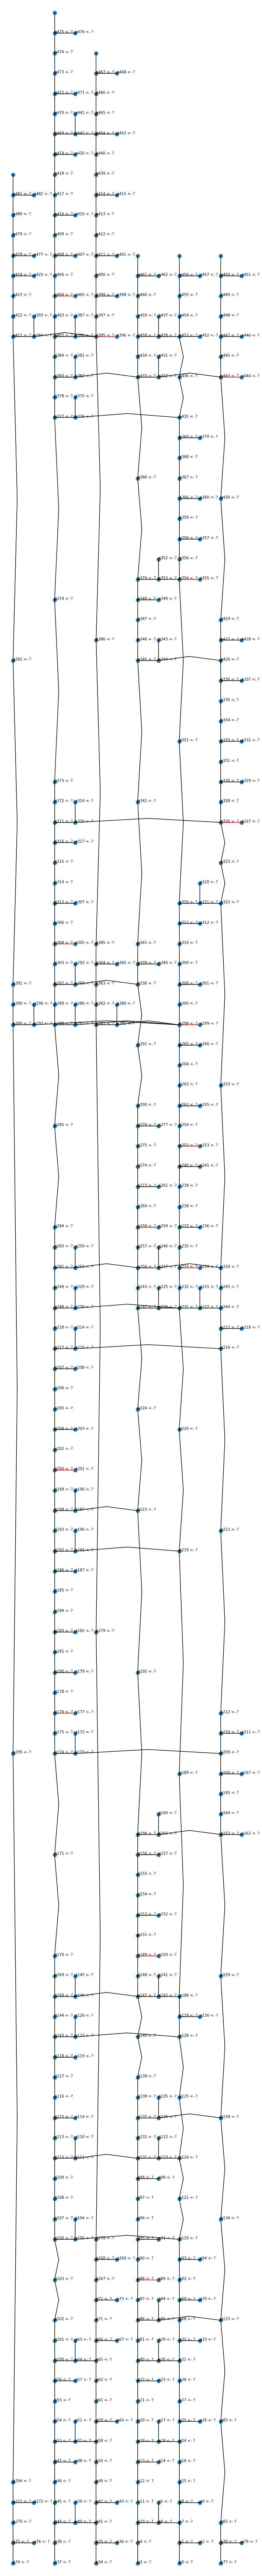

In [67]:
ppm_result_simple.draw('simple_optimized.png')